In [ ]:
! pip install emukit

In [ ]:
! pip install --upgrade pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18171 sha256=53d9b498394abadbeaa4cad323da6b75db0c882adb3e0e581cd815e598747239
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [ ]:
! pip install GPy

In [ ]:
import numpy as np
import pandas as pd
import emukit
import GPy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# **Loading the Data**

In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Bayesian Optimization and Quantum')

In [ ]:
df_initial = pd.read_excel("initial sample_Final.xlsx")
print(df_initial.shape)
df_initial.head()

(20, 15)


,sample_no,wg_width [nm],wg_height [nm],Radius [micron],Loss [dB/m],kappa,ng,neff,Aeff,center_WL [nm],QL,Qc,Pth [W],S [dB] - P=100mW,S [dB]
0,0,1800,970,140,60,0.361,2.11458,1.8707,1.33648,1550.84,49638.093292,53971.282278,6.447814,-0.412943,-10.003353
1,1,1100,850,155,90,0.221,2.14650,1.7990,0.94180,1550.40,120578.807906,169186.596381,1.100452,-2.087017,-5.278350
2,2,1300,820,110,10,0.281,2.13560,1.8167,0.99400,1550.12,71351.237370,72737.070247,1.710553,-1.549219,-13.691510
3,3,1400,700,50,30,0.421,2.12860,1.7992,0.96360,1552.40,13715.148637,13873.332978,20.212217,-0.132330,-14.481655
4,4,1250,940,95,80,0.481,2.13760,1.8311,1.04800,1550.29,18849.577253,19652.603840,22.822264,-0.117149,-12.003093


# **Set the variable space**

In [ ]:
w_min, w_max, w_step = [1000, 1800, 50] ## Unit: nm
w_var = np.arange(w_min, w_max+w_step, w_step)
w_num = len(w_var)

h_min, h_max, h_step = [700, 1000, 30] ## Unit: nm
h_var = np.arange(h_min, h_max+h_step, h_step)
h_num = len(h_var)

R_min, R_max, R_step = [50, 200, 15] ## Unit: micron
R_var = np.arange(R_min, R_max+R_step, R_step)
R_num = len(R_var)

Loss_min, Loss_max, Loss_step = [10, 200, 10] ## Unit: dB/m
Loss_var = np.arange(Loss_min, Loss_max+Loss_step, Loss_step)
Loss_num = len(Loss_var)

k_min, k_max, k_step = [0.001, 0.5, 0.02]
k_var = np.arange(k_min, k_max+k_step, k_step)
k_num = len(k_var)


var_array = [w_var, h_var, R_var, Loss_var, k_var]
x_labels = ['wg width [nm]',
            'wg height [nm]',
            'Radius [micron]',
            'Loss [dB/m]',
            'coupling coefficient']


def x_normalizer(X, var_array):

    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i],
                                         max(var_array[i]),
                                         min(var_array[i])) for i in range(len(x))])

    return x_norm

def x_denormalizer(x_norm, var_array):

    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i],
                                         max(var_array[i]),
                                         min(var_array[i])) for i in range(len(x))])

    return x_original

def get_closest_value(given_value, array_list):
    absolute_difference_function = lambda list_value : abs(list_value - given_value)
    closest_value = min(array_list, key=absolute_difference_function)
    return closest_value

def get_closest_array(suggested_x, var_list):
    modified_array = []
    var_list = var_array
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [ ]:
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign

parameter_space = ParameterSpace([ContinuousParameter('width', 0-1/(w_num-1)/2, 1+1/(w_num-1)/2),
                                 ContinuousParameter('height', 0-1/(h_num-1)/2, 1+1/(h_num-1)/2),
                                 ContinuousParameter('radius', 0-1/(R_num-1)/2, 1+1/(R_num-1)/2),
                                 ContinuousParameter('loss', 0-1/(Loss_num-1)/2, 1+1/(Loss_num-1)/2),
                                 ContinuousParameter('kappa', 0-1/(k_num-1)/2, 1+1/(k_num-1)/2)
                                 ])

In [ ]:
np.random.seed(10)

from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

x_init = x_normalizer(df_initial.iloc[:,1:6].values, var_array)
y_init = np.transpose([df_initial.iloc[:,-2].values])
X, Y = [x_init, y_init]

X = np.array(X)

input_dim = len(X[0])
ker = GPy.kern.Matern52(input_dim = input_dim, ARD =True)
ker.lengthscale.constrain_bounded(1e-1, 1)
ker.variance.constrain_bounded(1e-1, 1000.0)
model_gpy = GPRegression(X , -Y, ker)  #Emukit is a minimization tool; need to make Y negative
#model_gpy.Gaussian_noise.variance = 0.5**2
#model_gpy.Gaussian_noise.variance.fix()
model_gpy.randomize()
model_gpy.optimize_restarts(num_restarts=20,verbose =False, messages=False)
objective_model = GPyModelWrapper(model_gpy)

**Check the performance of regression model**

In [ ]:
f_obj =  objective_model.model.predict

y_pred, y_uncer = f_obj(X)
y_pred = -y_pred[:,-1]
y_uncer = np.sqrt(y_uncer[:,-1])

Text(0.5, 1.0, 'GPR for Obj Fcn (RMSE=0.00 [%])')

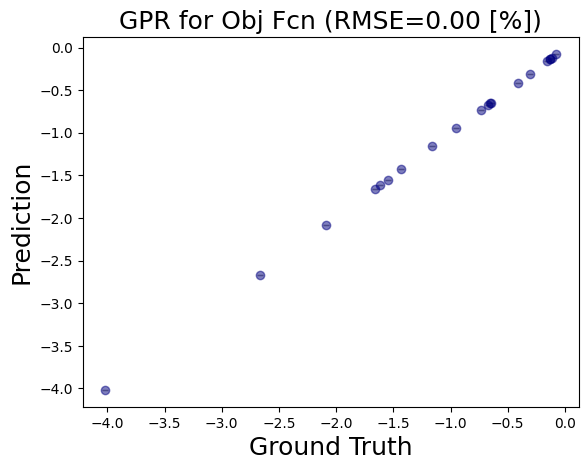

In [ ]:
from sklearn.metrics import mean_squared_error

fs = 18

plt.scatter(Y[:,-1], y_pred, alpha = 0.5, c = 'navy' , edgecolor = 'navy')
plt.errorbar(Y[:,-1], y_pred, yerr = y_uncer, ms = 0,
             ls = '', capsize = 2, alpha = 0.6,
             color = 'gray', zorder = 0)
rmse_value = np.sqrt(mean_squared_error(Y[:,-1], y_pred))
title = 'GPR for Obj Fcn' + " (RMSE=%.2f" % rmse_value+' [%])'
plt.xlabel('Ground Truth', fontsize = fs)
plt.ylabel('Prediction', fontsize = fs)
plt.title(title, fontsize = fs)

In [ ]:
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      MultipointExpectedImprovement,\
                                                      ProbabilityOfFeasibility

from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)

bayesopt= BayesianOptimizationLoop(model=objective_model,
                                     space=parameter_space,
                                     acquisition=acquisition,
                                     batch_size = 20)

X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)
X_new = x_normalizer(get_closest_array(x_denormalizer(X_new, var_array), var_array), var_array)

f_obj =  objective_model.model.predict

f_acq = bayesopt.candidate_point_calculator.acquisition.acquisition.evaluate

 /usr/local/lib/python3.10/dist-packages/emukit/bayesian_optimization/acquisitions/log_acquisition.py:25: RuntimeWarning:invalid value encountered in log


In [ ]:
df_Xnew = pd.DataFrame(get_closest_array(x_denormalizer(X_new, var_array), var_array), columns = df_initial.columns[1:6])
df_all = pd.concat([df_initial.iloc[:,1:6], df_Xnew])
df_all_ = df_all.drop_duplicates()
df_Xnew = df_all_.iloc[20:40]
#df_Xnew = df_Xnew.sort_values(by=list(df_initial.columns[1:6]), ignore_index = True)
df_Xnew.index = np.arange(len(df_Xnew))+len(df_initial)
df_Xnew

,wg_width [nm],wg_height [nm],Radius [micron],Loss [dB/m],kappa
20,1600.0,1000.0,80.0,10.0,0.161
21,1450.0,940.0,185.0,70.0,0.281
22,1000.0,790.0,185.0,200.0,0.161
23,1350.0,970.0,125.0,100.0,0.061
24,1550.0,880.0,155.0,80.0,0.241
25,1100.0,760.0,125.0,80.0,0.301
26,1350.0,760.0,140.0,70.0,0.061
27,1050.0,730.0,65.0,200.0,0.121
28,1550.0,820.0,140.0,200.0,0.261
29,1700.0,730.0,155.0,10.0,0.221


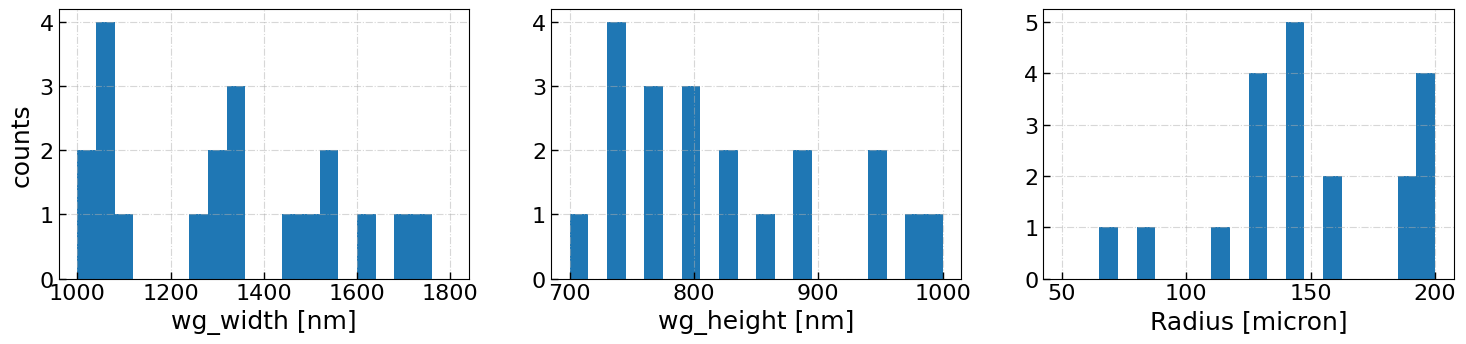

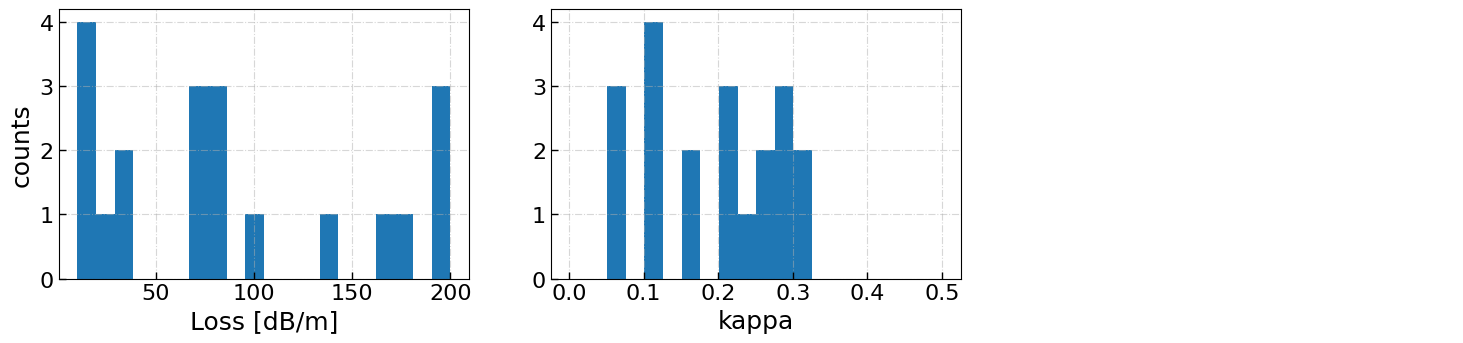

In [ ]:
df = df_Xnew
df_cols = df.columns
n_col = 3 # num of columns per row in the figure

for n in np.arange(0, 6, n_col):
    fig,axes = plt.subplots(1, n_col, figsize=(18, 3.5), sharey = False)
    fs = 20
    for i in np.arange(n_col):
        if n< len(df_cols):
            axes[i].hist(df.iloc[:,n], bins= 20, range = (min(var_array[n]),max(var_array[n])))####
            axes[i].set_xlabel(df_cols[n], fontsize = 18)
            #axes[i].set_xlim(min(var_array[n])*0.8,max(var_array[n])*1.05)
        else:
            axes[i].axis("off")
        n = n+1
    axes[0].set_ylabel('counts', fontsize = 18)
    for i in range(len(axes)):
        axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
        axes[i].grid(True, linestyle='-.')
    plt.show()

In [ ]:
df_all.to_csv('BO_First Round.csv', index=False)